In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
import os
from PIL import Image

# 1. Lectura de los datos

In [26]:
base_dir = os.path.join(os.getcwd(), 'GroceryStoreDataset', 'dataset')


def load_dataframe(subset):
    return pd.read_csv(os.path.join(base_dir, subset + '.txt'),
                       sep=",", 
                       header=None, 
                       names=['image_path', 'class_id', 'coarse_class_id'], 
                       dtype=str)

# Crear DataFrames para entrenamiento, validación y prueba
train_df = load_dataframe("train")
valid_df = load_dataframe("val")
test_df = load_dataframe("test")

# Exploración inicial
print("Número de imágenes de entrenamiento:", len(train_df))
print("Número de imágenes de validación:", len(valid_df))
print("Número de imágenes de prueba:", len(test_df))
print("Primeras filas del DataFrame de entrenamiento:")
print(train_df.head())

Número de imágenes de entrenamiento: 2640
Número de imágenes de validación: 296
Número de imágenes de prueba: 2485
Primeras filas del DataFrame de entrenamiento:
                                          image_path class_id coarse_class_id
0  train/Fruit/Apple/Golden-Delicious/Golden-Deli...        0               0
1  train/Fruit/Apple/Golden-Delicious/Golden-Deli...        0               0
2  train/Fruit/Apple/Golden-Delicious/Golden-Deli...        0               0
3  train/Fruit/Apple/Golden-Delicious/Golden-Deli...        0               0
4  train/Fruit/Apple/Golden-Delicious/Golden-Deli...        0               0


In [27]:
train_df.shape

(2640, 3)

In [28]:
valid_df.shape

(296, 3)

In [29]:
test_df.shape

(2485, 3)

In [30]:
classes = pd.read_csv('GroceryStoreDataset\dataset\classes.csv')
classes.head(5)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\kevin\AppData\Local\Temp\ipykernel_9972\1136431760.py:1: SyntaxWarning: invalid escape sequence '\d'
  classes = pd.read_csv('GroceryStoreDataset\dataset\classes.csv')


,Class Name (str),Class ID (int),Coarse Class Name (str),Coarse Class ID (int),Iconic Image Path (str),Product Description Path (str)
0,Golden-Delicious,0,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Go...,/iconic-images-and-descriptions/Fruit/Apple/Go...
1,Granny-Smith,1,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Gr...,/iconic-images-and-descriptions/Fruit/Apple/Gr...
2,Pink-Lady,2,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Pi...,/iconic-images-and-descriptions/Fruit/Apple/Pi...
3,Red-Delicious,3,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Re...,/iconic-images-and-descriptions/Fruit/Apple/Re...
4,Royal-Gala,4,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Ro...,/iconic-images-and-descriptions/Fruit/Apple/Ro...


In [31]:
diccionario = dict(zip(classes['Coarse Class ID (int)'], classes['Coarse Class Name (str)']))
print(diccionario)

{0: 'Apple', 1: 'Avocado', 2: 'Banana', 3: 'Kiwi', 4: 'Lemon', 5: 'Lime', 6: 'Mango', 7: 'Melon', 8: 'Nectarine', 9: 'Orange', 10: 'Papaya', 11: 'Passion-Fruit', 12: 'Peach', 13: 'Pear', 14: 'Pineapple', 15: 'Plum', 16: 'Pomegranate', 17: 'Red-Grapefruit', 18: 'Satsumas', 19: 'Juice', 20: 'Milk', 21: 'Oatghurt', 22: 'Oat-Milk', 23: 'Sour-Cream', 24: 'Sour-Milk', 25: 'Soyghurt', 26: 'Soy-Milk', 27: 'Yoghurt', 28: 'Asparagus', 29: 'Aubergine', 30: 'Cabbage', 31: 'Carrots', 32: 'Cucumber', 33: 'Garlic', 34: 'Ginger', 35: 'Leek', 36: 'Mushroom', 37: 'Onion', 38: 'Pepper', 39: 'Potato', 40: 'Red-Beet', 41: 'Tomato', 42: 'Zucchini'}


In [32]:
train_df.dtypes

image_path         object
class_id           object
coarse_class_id    object
dtype: object

In [33]:
for datos in [train_df, valid_df, test_df]:
    datos['class_id'] = datos['class_id'].str.replace(',', '').astype(int)
    datos['coarse_class_id'] = datos['coarse_class_id'].str.replace(',', '').astype(int)

In [34]:
for datos in [train_df, valid_df, test_df]:
    datos['coarse_class_name'] = datos['coarse_class_id'].map(diccionario)

In [35]:
train_df.dtypes

image_path           object
class_id              int32
coarse_class_id       int32
coarse_class_name    object
dtype: object

In [36]:
train_df.head(5)

,image_path,class_id,coarse_class_id,coarse_class_name
0,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Apple
1,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Apple
2,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Apple
3,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Apple
4,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Apple


# 2. Estructuras de los datos

In [37]:
print("Dimensiones de los datasets:")
print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")
print(f"Val: {valid_df.shape}")

Dimensiones de los datasets:
Train: (2640, 4)
Test: (2485, 4)
Val: (296, 4)



Características de las Imágenes:
Formato de las Imágenes: JPEG
Resolución: Redimensionadas a (150, 150) píxeles
Canales de Color: RGB (3 canales)
Normalización: Los valores de los píxeles se escalan entre 0 y 1


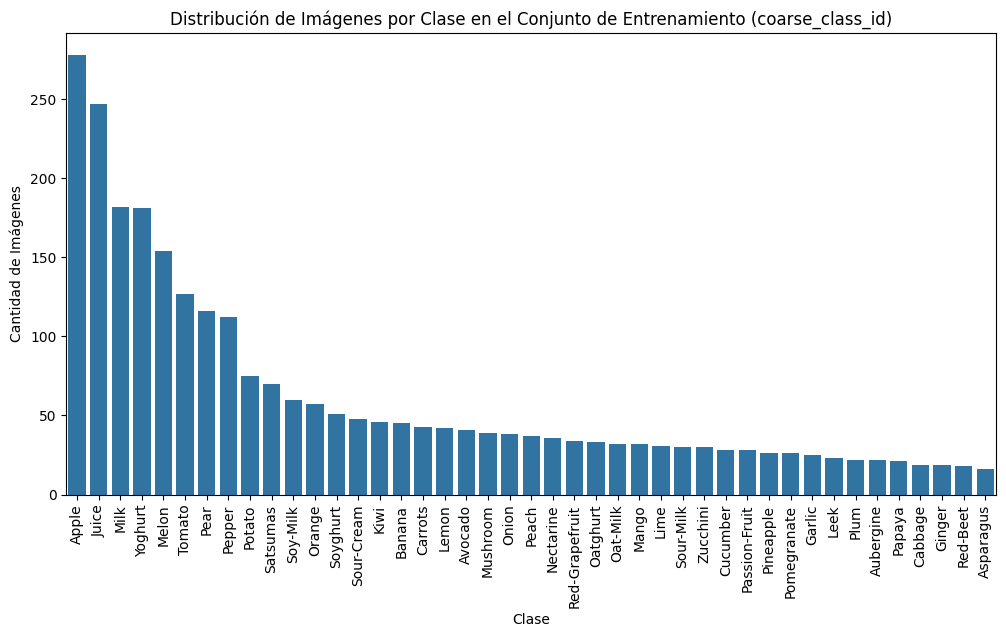

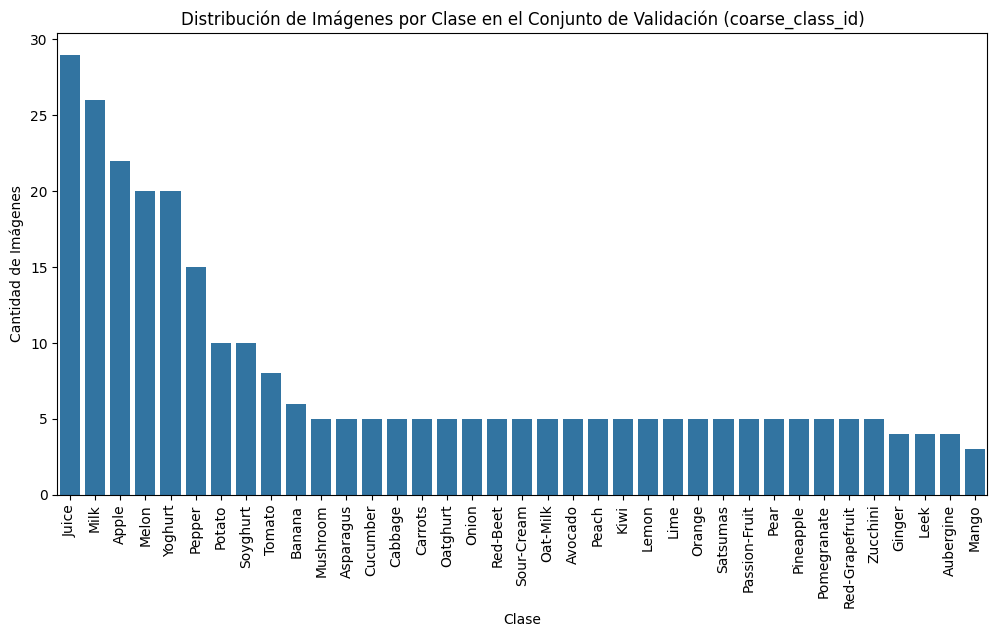

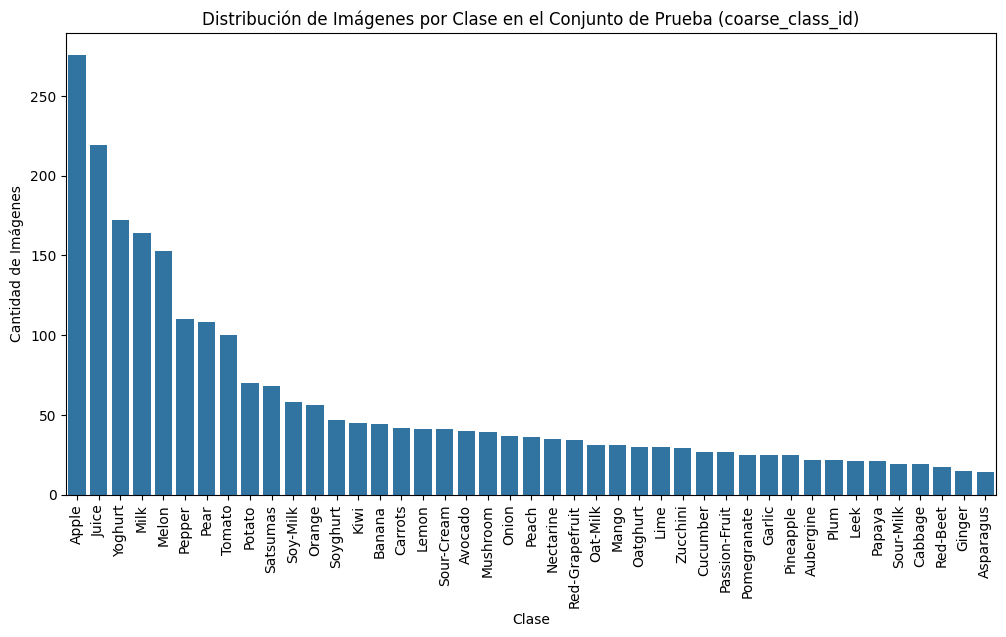


Indicadores Importantes:
- Número de clases (coarse_class_name): 43
- Equilibrio de Clases: Evaluar la distribución para ver si hay un desequilibrio significativo
- Tamaño de Imagen: Las imágenes se redimensionan a (150, 150) para el entrenamiento
- Aumento de Datos: Se usarán técnicas como rotación, cambio de escala, y espejado


In [38]:
# Características de las imágenes
print("\nCaracterísticas de las Imágenes:")
print("Formato de las Imágenes: JPEG")
print("Resolución: Redimensionadas a (150, 150) píxeles")
print("Canales de Color: RGB (3 canales)")
print("Normalización: Los valores de los píxeles se escalan entre 0 y 1")

# Contar el número de imágenes por clase usando `coarse_class_name`
class_counts_train = train_df['coarse_class_name'].value_counts()

# Visualizar la distribución de las clases
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts_train.index, y=class_counts_train.values)
plt.title("Distribución de Imágenes por Clase en el Conjunto de Entrenamiento (coarse_class_id)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de Imágenes")
plt.xticks(rotation=90)
plt.show()

# Contar el número de imágenes por clase usando `coarse_class_name`
class_counts_valid = valid_df['coarse_class_name'].value_counts()

# Visualizar la distribución de las clases
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts_valid.index, y=class_counts_valid.values)
plt.title("Distribución de Imágenes por Clase en el Conjunto de Validación (coarse_class_id)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de Imágenes")
plt.xticks(rotation=90)
plt.show()

# Contar el número de imágenes por clase usando `coarse_class_name`
class_counts_test = test_df['coarse_class_name'].value_counts()

# Visualizar la distribución de las clases
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts_test.index, y=class_counts_test.values)
plt.title("Distribución de Imágenes por Clase en el Conjunto de Prueba (coarse_class_id)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de Imágenes")
plt.xticks(rotation=90)
plt.show()

# Indicadores importantes
print("\nIndicadores Importantes:")
print("- Número de clases (coarse_class_name):", len(class_counts_train))
print("- Equilibrio de Clases: Evaluar la distribución para ver si hay un desequilibrio significativo")
print("- Tamaño de Imagen: Las imágenes se redimensionan a (150, 150) para el entrenamiento")
print("- Aumento de Datos: Se usarán técnicas como rotación, cambio de escala, y espejado")

Como vemos, los productos que más aparecen en el dataset de imágenes son manzanas, jugos y leche. Por lo cual se nota que el dataset está bastante desbalanceado y con sesgo hacia ciertas clases.

In [39]:
# Eliminar caracteres no deseados al final de las rutas
train_df['image_path'] = train_df['image_path'].str.strip().str.rstrip(',')
valid_df['image_path'] = valid_df['image_path'].str.strip().str.rstrip(',')
test_df['image_path'] = test_df['image_path'].str.strip().str.rstrip(',')

In [40]:
# Configuración para el aumento de datos
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Elegir qué etiqueta usar: 'class_id' o 'coarse_class_id'
label_col = 'coarse_class_id'

train_df["label"] = train_df[label_col].astype('str')
valid_df["label"] = valid_df[label_col].astype('str')

# Configurar los generadores con la lista completa de clases
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=base_dir,
    x_col='image_path',
    y_col='label', 
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=base_dir,
    x_col='image_path',
    y_col='label',
    target_size=(150, 150),
    batch_size=32, 
    class_mode='categorical',
    classes=train_generator.class_indices
    
)


Found 2640 validated image filenames belonging to 43 classes.
Found 296 validated image filenames belonging to 43 classes.


In [41]:
# Obtener el número de clases del generador
num_classes = len(train_generator.class_indices)

print("Número de clases en train_generator:", num_classes)
print(len(val_generator.class_indices))

Número de clases en train_generator: 43
43


In [42]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [43]:
# Modelo 1: CNN básica
model1 = models.Sequential([
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Cambiar aquí para que coincida con el número de clases
])

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

# Entrenar el modelo 1
history1 = model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)


c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9248)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       591,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 690,571 (2.63 MB)

 Trainable params: 690,571 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 45s 531ms/step - accuracy: 0.1033 - loss: 3.4341 - val_accuracy: 0.1926 - val_loss: 3.1286
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 63s 763ms/step - accuracy: 0.2060 - loss: 2.8346 - val_accuracy: 0.2027 - val_loss: 2.7725
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 46s 552ms/step - accuracy: 0.2967 - loss: 2.3974 - val_accuracy: 0.2230 - val_loss: 2.7041
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.3839 - loss: 2.0927 - val_accuracy: 0.2804 - val_loss: 2.4423
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.3975 - loss: 1.9789 - val_accuracy: 0.3074 - val_loss: 2.3863
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4408 - loss: 1.7552 - val_accuracy: 0.3007 - val_loss: 2.3279
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.5062 - loss: 1.5281 - val_accuracy: 0.3345 - val_loss: 2.3888
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5188 - loss: 1.4827 - val_accuracy: 0.3851

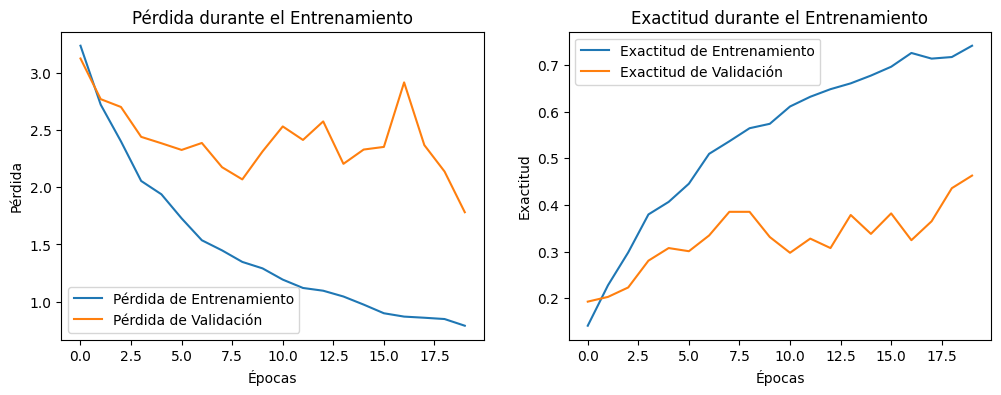

In [44]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Gráfica de la pérdida
    plt.figure(figsize=(12, 4))
    
    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title('Pérdida durante el Entrenamiento')

    # Exactitud
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Exactitud de Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Exactitud de Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Exactitud')
    plt.legend()
    plt.title('Exactitud durante el Entrenamiento')

    plt.show()

# Llama a la función con el historial de entrenamiento
plot_training_history(history1)


In [45]:
# Evaluar el modelo en el conjunto de prueba

test_df["label"] = test_df[label_col].astype('str')
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_dir,
    x_col='image_path',
    y_col='label',
    target_size=(150, 150),
    batch_size=32, 
    class_mode='categorical'
)

model1.evaluate(test_generator)

Found 2485 validated image filenames belonging to 43 classes.


c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 18s 236ms/step - accuracy: 0.4917 - loss: 1.8338


[1.829292893409729, 0.4985915422439575]

In [46]:
# Predicciones y evaluación para el modelo 1
preds1 = model1.predict(test_generator)


78/78 ━━━━━━━━━━━━━━━━━━━━ 18s 233ms/step


In [47]:
preds1_classes = np.argmax(preds1, axis=1)
true_classes = test_generator.classes

print("Reporte de clasificación para el modelo 1:")
print(classification_report(true_classes, preds1_classes))

Reporte de clasificación para el modelo 1:
              precision    recall  f1-score   support

           0       0.13      0.12      0.12       276
           1       0.03      0.03      0.03        40
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        27
           4       0.00      0.00      0.00        36
           5       0.04      0.05      0.04       108
           6       0.00      0.00      0.00        25
           7       0.00      0.00      0.00        22
           8       0.00      0.00      0.00        25
           9       0.03      0.03      0.03        34
          10       0.00      0.00      0.00        68
          11       0.11      0.16      0.13       219
          12       0.00      0.00      0.00        44
          13       0.05      0.04      0.04       164
          14       0.00      0.00      0.00        30
          15       0.06      0.03      0.04        31
          16       0.03      0.02     

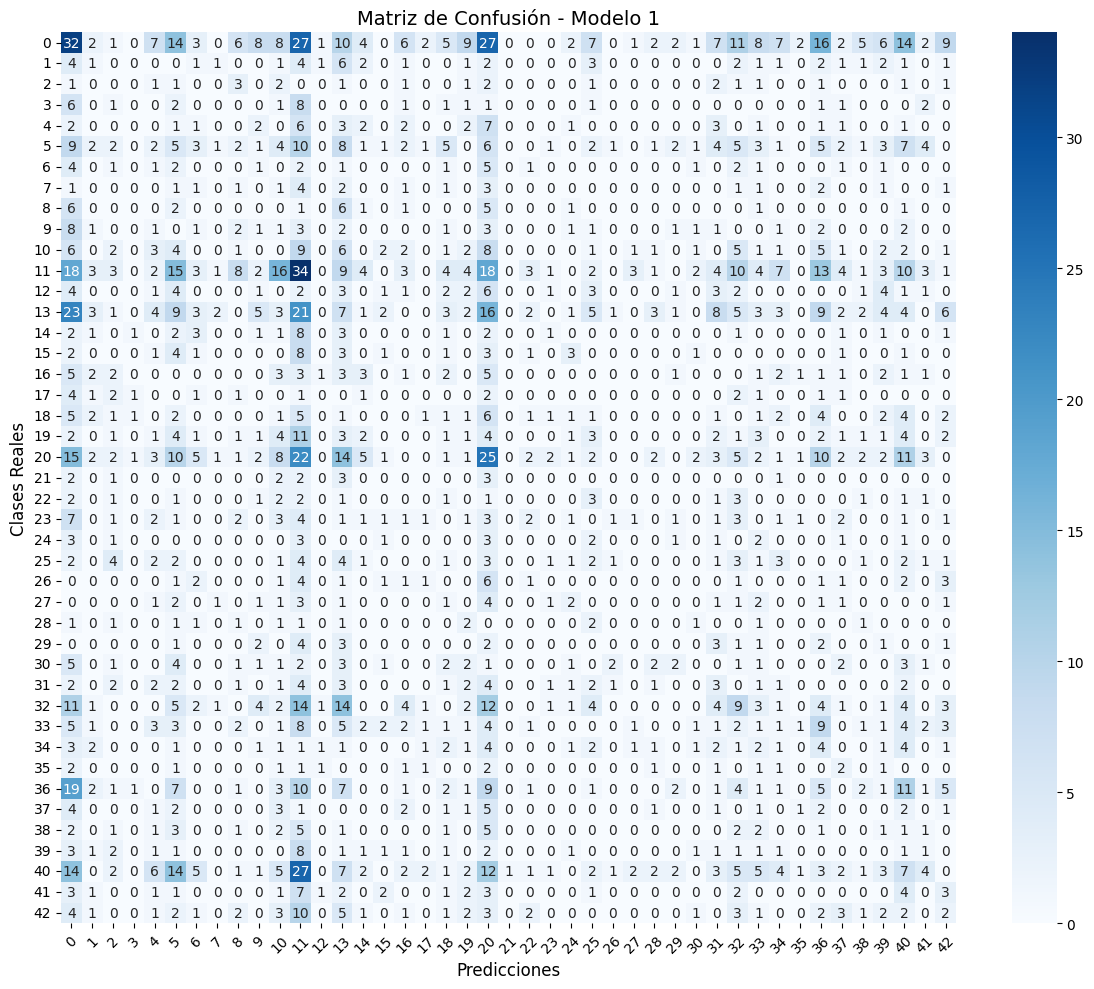

In [48]:
conf_matrix1 = confusion_matrix(true_classes, preds1_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', cbar=True)

# Configurar etiquetas y título
plt.xlabel('Predicciones', fontsize=12)
plt.ylabel('Clases Reales', fontsize=12)
plt.title("Matriz de Confusión - Modelo 1", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Mostrar la matriz de confusión
plt.tight_layout()
plt.show()

# Análisis de resultados
### Precisión (Accuracy) del 6%:

La precisión general del modelo es muy baja, lo que significa que solo el 6% de las predicciones fueron correctas. Esto indica que el modelo no está aprendiendo de manera efectiva las características necesarias para distinguir entre las 43 clases.

### Precisión, Recall y F1-Score:

* Precisión: Muy baja en la mayoría de las clases, lo que sugiere que el modelo hace muchas predicciones incorrectas para cada clase.
* Recall: Muy bajo, lo que significa que el modelo no está capturando correctamente la mayoría de los ejemplos reales de cada clase.
* F1-Score: Las puntuaciones F1 también son muy bajas, indicando un desequilibrio entre precisión y recall, lo cual es malo para un modelo de clasificación.

### Matriz de confusión:

La matriz de confusión muestra que el modelo tiene dificultad para hacer predicciones correctas en la mayoría de clases. 
Las casillas diagonales muestran valores bajos, mientras que muchas otras casillas están dispersas, indicando confusión entre clases.
Algunas clases parecen tener un mejor desempeño relativo como la 11, 13 y 36, pero siguen siendo insuficientes para un buen rendimiento global.

### Impacto y valor para la empresa

* Riesgo de implementación: Con un accuracy del 6%, el modelo no es lo suficientemente confiable para ser usado en un entorno de producción. Las predicciones incorrectas podrían generar costos adicionales, como correcciones manuales, retrasos en el servicio, o incluso pérdidas económicas si se toman decisiones basadas en resultados erróneos.
* Costo de los errores: Un modelo que comete errores frecuentes podría aumentar el tiempo y costo asociados al registro o identificación de productos, afectando la eficiencia y generando una experiencia negativa para los clientes y empleados.

### Elementos que impactaron positivamente
* Aumento de Datos: Es posible que haya ayudado a mejorar ligeramente el rendimiento en ciertas clases, pero no lo suficiente para un resultado aceptable.
* Arquitectura de la CNN: Por la estructura de la red neuronal CNN básica es probable que la capacidad actual del modelo no sea lo suficiente para manejar la complejidad del problema.

### Oportunidades de mejora
* Usar Transfer Learning: Usar un modelo preentrenado como ResNet50 podría ayudar a mejorar el rendimiento del modelo ya que tienen características aprendidas que podrían ser útiles para el problema.

* Aumento de Datos Más diversificado: Implementar técnicas avanzadas de aumento de datos para introducir más variabilidad y reducir el riesgo de sobreajuste.

* Balanceo de Clases: Si algunas clases tienen muchos menos ejemplos que otras, se podría usar técnicas de sobremuestreo o ponderación para equilibrar el conjunto de datos.

### Conclusión
El modelo actual no es lo suficientemente bueno para ser utilizado de manera efectiva, ya que tiene un rendimiento muy bajo en casi todas las clases.